In [9]:
import torch
import pyro
import pyro.infer as infer
import pyro.optim
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

torch.manual_seed(101)

In [10]:
def scale(guess):
    # The prior over the weights encodes the uncertainity about our guess
    w  = pyro.sample('weight', dist.Normal(guess, 1.0))
    # The measurement fluctuates around the true weight
    m = pyro.sample('measurement', dist.Normal(w, 0.75))
    return m

In [11]:
# Marginalization in pyro
posterior = infer.Importance(scale, num_samples=100)

In [12]:
# Run inference for a single input value


guess = 8.5

marginal = infer.EmpiricalMarginal(posterior.run(guess))
print(marginal())



tensor(8.0281)


Text(0,0.5,'#')

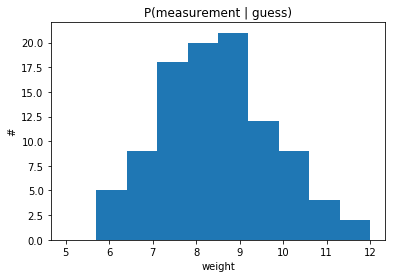

In [13]:
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")

In [14]:
# Conditioning Models on Data


conditioned_scale = pyro.condition(
    scale, data={"measurement": 9.5})



In [15]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

In [16]:
def scale2(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    tolerance = torch.abs(pyro.sample("tolerance", dist.Normal(0., 1.)))
    return pyro.sample("measurement", dist.Normal(weight, tolerance))


# conditioning composes:
# the following are all equivalent and do not interfere with each other
conditioned_scale2_1 = pyro.condition(
    pyro.condition(scale2, data={"weight": 9.2}),
    data={"measurement": 9.5})

conditioned_scale2_2 = pyro.condition(
    pyro.condition(scale2, data={"measurement": 9.5}),
    data={"weight": 9.2})

conditioned_scale2_3 = pyro.condition(
    scale2, data={"weight": 9.2, "measurement": 9.5})


tensor(9.2143)


Text(0,0.5,'#')

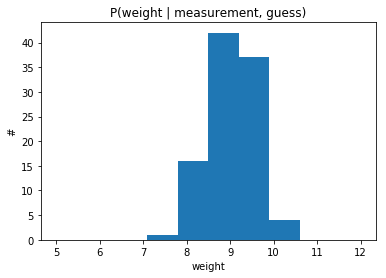

In [20]:
guess = 8.5
measurement = 9.5

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100).run(guess), sites="weight")

# The marginal distribution concentrates around the data
print(marginal())
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

In [21]:
# The above demonstrated method is slow so we would instead use a guide distribution that try to sample from it
"""
Guide function should generally be chosen so that it closely approximates the distribution over all unobserved sample statements in the model. 
The simplest guide for deferred_conditioned_scale matches the prior distribution over weight
"""

def scale_prior_guide(guess):
    return pyro.sample("weight", dist.Normal(guess, 1.))

posterior = pyro.infer.Importance(conditioned_scale,
                                  guide=scale_prior_guide,
                                  num_samples=10)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")




In [22]:
# We can actually do better since we can write the true posterior analytically


def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements
    # that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = 1. / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.Normal(a, b))

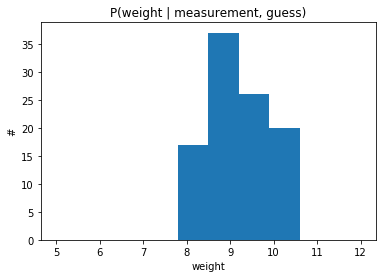

In [23]:
posterior = pyro.infer.Importance(deferred_conditioned_scale,
                                  guide=scale_posterior_guide,
                                  num_samples=20)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(torch.tensor([measurement]), guess), sites="weight")
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

Before guide parameter optimization 
tensor([ 9.1251])
tensor([ 0.6701])


 After applying stochastic variational inference 
tensor([ 9.1216])
tensor([-0.5954])


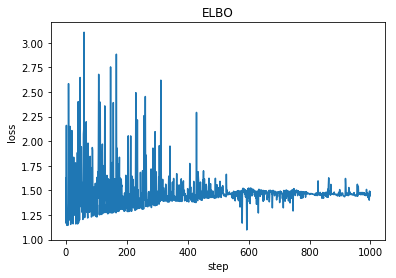

In [28]:
# Parametrized stochastic functions and variational inference
"""
Although we could write out the exact posterior distribution for scale, in general it is intractable to specify a guide that is a good approximation to
the posterior distribution of an arbitrary conditioned stochastic function. What we can do instead is use the top-level function pyro.param to specify
a family of guides indexed by named parameters, and search for 
the member of that family that is the best approximation. This approach to approximate posterior inference is called variational inference.

"""



def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(torch.randn(1) + guess))
    b = pyro.param("b", torch.randn(1))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

print("Before guide parameter optimization ")
print(pyro.param("a"))
print(pyro.param("b"))


pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
for t in range(1000):
    losses.append(svi.step(guess))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");


print(" After applying stochastic variational inference ")
print(pyro.param("a"))
print(pyro.param("b"))



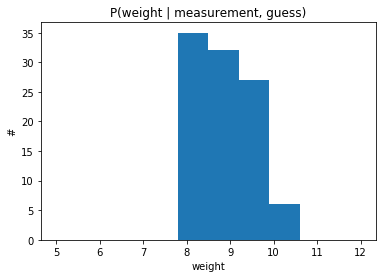

In [29]:

posterior = pyro.infer.Importance(conditioned_scale, scale_parametrized_guide, num_samples=10)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")

plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")



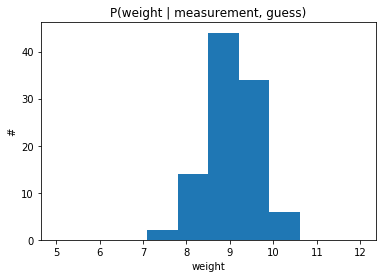

In [30]:
# We can also sample from the guide as an approximate posterior
plt.hist([scale_parametrized_guide(guess).item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")